# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

/Users/badeyemi/anaconda/envs/aind/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['LOVE', 'CORN1', 'SOMETHING-ONE', 'WONT', 'PREFER', 'FRED', 'HOMEWORK', 'KNOW', 'CHICAGO', 'YESTERDAY', 'IX', 'BILL', 'HERE', 'NEXT-WEEK', 'HAVE', 'POSS', 'LEG', 'SHOULD', 'READ', 'STUDENT', 'GO', 'VISIT', 'MARY', 'SUE', 'PAST', 'JANA', 'FUTURE', 'PUTASIDE', 'HOUSE', 'OLD', 'FRIEND', 'BROCCOLI', 'WHO', 'BOY', 'CHOCOLATE', 'GIVE', 'SAY-1P', 'PEOPLE', 'EAT', 'CANDY', 'WHAT', 'GROUP', 'LIVE', 'BUT', 'NEW', 'MAN', 'GO1', 'WILL', 'LEAVE', 'TOY1', 'FRANK', 'BROTHER', 'NOT', 'JOHN', 'VEGETABLE', 'BUY', 'SELL', 'FISH', 'TELL', 'BOOK', 'TOMORROW', 'SEARCH-FOR', 'VIDEOTAPE', 'BREAK-DOWN', 'BOX', 'FINISH', 'HIT', 'MANY', 'COAT', 'POTATO', 'BUY1', 'GIVE3', 'SELF', 'MOTHER', 'LAST-WEEK', 'GIVE1', 'PARTY', 'CHICKEN', 'TOY', 'WRITE', 'STOLEN', 'CHINA', 'WOMAN', 'WANT', 'CAR', 'GET', 'GIVE2', 'THINK', 'GIRL', 'BORROW', 'NAME', 'CORN', 'LIKE', 'DECIDE', 'APPLE', 'BLAME', 'THROW', 'FUTURE1', 'FIND', 'MOVIE', 'BLUE', 'SEE', 'SAY', 'TEACHER', 'ANN', 'ALL', 'NEW-YORK', 'SHOOT', 'IX-1P', 'C

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [10]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
df_std

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

# Add the individual mean values to the dataframe
asl.df['left-x-mean'] = asl.df['speaker'].map(df_means['left-x'])
asl.df['left-y-mean'] = asl.df['speaker'].map(df_means['left-y'])
asl.df['right-x-mean'] = asl.df['speaker'].map(df_means['right-x'])
asl.df['right-y-mean'] = asl.df['speaker'].map(df_means['right-y'])

asl.df['left-x-std'] = asl.df['speaker'].map(df_std['left-x'])
asl.df['left-y-std'] = asl.df['speaker'].map(df_std['left-y'])
asl.df['right-x-std'] = asl.df['speaker'].map(df_std['right-x'])
asl.df['right-y-std'] = asl.df['speaker'].map(df_std['right-y'])

# Carry out per-speaker normalization using Z-score scaling (X - Xmean)/Xstd
asl.df['norm-rx'] = (asl.df['right-x'] - asl.df['right-x-mean']) / asl.df['right-x-std']
asl.df['norm-ry'] = (asl.df['right-y'] - asl.df['right-y-mean']) / asl.df['right-y-std']
asl.df['norm-lx'] = (asl.df['left-x'] - asl.df['left-x-mean']) / asl.df['left-x-std']
asl.df['norm-ly'] = (asl.df['left-y'] - asl.df['left-y-mean']) / asl.df['left-y-std']

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

asl.df[features_norm].head()

norm-rx   norm-ry   norm-lx   norm-ly
video frame                                        
98    0      1.153232  1.663433 -0.891199  0.741835
      1      1.153232  1.663433 -0.891199  0.741835
      2      1.153232  1.663433 -0.891199  0.741835
      3      1.153232  1.663433 -0.891199  0.741835
      4      1.153232  1.663433 -0.891199  0.741835

In [12]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

asl.df['polar-rr'] = np.sqrt(asl.df['grnd-rx'] ** 2 + asl.df['grnd-ry'] ** 2)
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])
asl.df['polar-lr'] = np.sqrt(asl.df['grnd-lx'] ** 2 + asl.df['grnd-ly'] ** 2)
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

asl.df[features_polar].head()

polar-rr  polar-rtheta    polar-lr  polar-ltheta
video frame                                                   
98    0      113.35784      0.079478  119.603512     -0.100501
      1      113.35784      0.079478  119.603512     -0.100501
      2      113.35784      0.079478  119.603512     -0.100501
      3      113.35784      0.079478  119.603512     -0.100501
      4      113.35784      0.079478  119.603512     -0.100501

In [13]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']
asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(value=0)
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(value=0)
asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(value=0)
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(value=0)

asl.df[features_delta].head(50)

delta-rx  delta-ry  delta-lx  delta-ly
video frame                                        
98    0           0.0       0.0       0.0       0.0
      1           0.0       0.0       0.0       0.0
      2           0.0       0.0       0.0       0.0
      3           0.0       0.0       0.0       0.0
      4           0.0       0.0       0.0       0.0
      5           0.0       0.0       0.0       0.0
      6           0.0       0.0       0.0       0.0
      7           0.0       0.0       0.0       0.0
      8           0.0       0.0       0.0       0.0
      9           0.0       0.0       0.0       0.0
      10          0.0       0.0       0.0       0.0
      11         -1.0      -2.0       0.0       0.0
      12         -2.0      -8.0       0.0       0.0
      13         -1.0      -5.0       0.0       0.0
      14         -2.0     -11.0       0.0       0.0
      15         -6.0     -16.0       0.0       0.0
      16         -5.0     -14.0       0.0       0.0
      17        -13.0     -10.0       0.0       0.0
      18        -14.0      -9.0       0.0       0.0
      19        -12.0      -6.0       0.0       0.0
      20         -4.0      -5.0       0.0       0.0
      21          0.0       0.0       0.0       0.0
      22          5.0      -3.0       0.0       0.0
      23          9.0      -3.0       0.0       0.0
      24          3.0       1.0       0.0       0.0
      25          5.0      -1.0       0.0       0.0
      26          3.0      -1.0       0.0       0.0
      27          3.0      -3.0       0.0       0.0
      28          3.0      -4.0       0.0       0.0
      29          0.0       0.0       0.0       0.0
      30          0.0       0.0       0.0       0.0
      31          0.0       0.0       0.0       0.0
      32          0.0       0.0       0.0       0.0
      33          0.0       0.0       0.0       0.0
      34          0.0       0.0       0.0       0.0
      35          0.0       0.0       6.0      -9.0
      36          0.0       0.0      -4.0      -2.0
      37          0.0       0.0      -2.0      11.0
      38          0.0       0.0      13.0     -25.0
      39          0.0       0.0       5.0     -10.0
      40         -1.0      10.0      10.0     -10.0
      41         -1.0       3.0       0.0       0.0
      42          2.0       9.0       0.0     -16.0
      43          8.0       6.0      -3.0      -7.0
      44          8.0       0.0       0.0       0.0
      45         12.0       1.0     -12.0       3.0
      46         -4.0      -4.0      -4.0       3.0
      47         -6.0      -4.0      -2.0       3.0
      48         -7.0     -11.0       3.0      -1.0
      49        -10.0     -10.0       7.0      -6.0

In [14]:
# Preview Dataframe
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly    ...      norm-lx   norm-ly  \
video frame                               ...                          
98    0          113        9      119    ...    -0.891199  0.741835   
      1          113        9      119    ...    -0.891199  0.741835   
      2          113        9      119    ...    -0.891199  0.741835   
      3          113        9      119    ...    -0.891199  0.741835   
      4          113        9      119    ...    -0.891199  0.741835   

              polar-rr  polar-rtheta    polar-lr  polar-ltheta  delta-rx  \
video frame                                                                
98    0      113.35784      0.079478  119.603512     -0.100501       0.0   
      1      113.35784      0.079478  119.603512     -0.100501       0.0   
      2      113.35784      0.079478  119.603512     -0.100501       0.0   
      3      113.35784      0.079478  119.603512     -0.100501       0.0   
      4      113.35784      0.079478  119.603512     -0.100501       0.0   

             delta-ry  delta-lx  delta-ly  
video frame                                
98    0           0.0       0.0       0.0  
      1           0.0       0.0       0.0  
      2           0.0       0.0       0.0  
      3           0.0       0.0       0.0  
      4           0.0       0.0       0.0  

[5 rows x 31 columns]

In [15]:
 
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

# Add Z-score normalized by speaker values of 'grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly' representing
# differences between hand and nose locations
asl.df['grnd-rx-mean'] = asl.df['speaker'].map(df_means['grnd-rx'])
asl.df['grnd-ry-mean'] = asl.df['speaker'].map(df_means['grnd-ry'])
asl.df['grnd-lx-mean'] = asl.df['speaker'].map(df_means['grnd-lx'])
asl.df['grnd-ly-mean'] = asl.df['speaker'].map(df_means['grnd-ly'])

asl.df['grnd-rx-std'] = asl.df['speaker'].map(df_std['grnd-rx'])
asl.df['grnd-ry-std'] = asl.df['speaker'].map(df_std['grnd-ry'])
asl.df['grnd-lx-std'] = asl.df['speaker'].map(df_std['grnd-lx'])
asl.df['grnd-ly-std'] = asl.df['speaker'].map(df_std['grnd-ly'])

asl.df['grnd-rx-norm'] = (asl.df['grnd-rx'] - asl.df['grnd-rx-mean']) / asl.df['grnd-rx-std']
asl.df['grnd-ry-norm'] = (asl.df['grnd-ry'] - asl.df['grnd-ry-mean']) / asl.df['grnd-ry-std']
asl.df['grnd-lx-norm'] = (asl.df['grnd-lx'] - asl.df['grnd-lx-mean']) / asl.df['grnd-lx-std']
asl.df['grnd-ly-norm'] = (asl.df['grnd-ly'] - asl.df['grnd-ly-mean']) / asl.df['grnd-ly-std']

features_ground_norm = ['grnd-rx-norm', 'grnd-ry-norm', 'grnd-lx-norm', 'grnd-ly-norm']

# Add Z-score normalized by speaker values for 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
df_means = asl.df.groupby('speaker').mean()
df_std = asl.df.groupby('speaker').std()

asl.df['polar-rr-mean'] = asl.df['speaker'].map(df_means['polar-rr'])
asl.df['polar-rtheta-mean'] = asl.df['speaker'].map(df_means['polar-rtheta'])
asl.df['polar-lr-mean'] = asl.df['speaker'].map(df_means['polar-lr'])
asl.df['polar-ltheta-mean'] = asl.df['speaker'].map(df_means['polar-ltheta'])

asl.df['polar-rr-std'] = asl.df['speaker'].map(df_std['polar-rr'])
asl.df['polar-rtheta-std'] = asl.df['speaker'].map(df_std['polar-rtheta'])
asl.df['polar-lr-std'] = asl.df['speaker'].map(df_std['polar-lr'])
asl.df['polar-ltheta-std'] = asl.df['speaker'].map(df_std['polar-ltheta'])

asl.df['polar-rr-norm'] = (asl.df['polar-rr'] - asl.df['polar-rr-mean']) / asl.df['polar-rr-std']
asl.df['polar-rtheta-norm'] = (asl.df['polar-rtheta'] - asl.df['polar-rtheta-mean']) / asl.df['polar-rtheta-std']
asl.df['polar-lr-norm'] = (asl.df['polar-lr'] - asl.df['polar-lr-mean']) / asl.df['polar-lr-std']
asl.df['polar-ltheta-norm'] = (asl.df['polar-ltheta'] - asl.df['polar-ltheta-mean']) / asl.df['polar-ltheta-std']

features_polar_norm = ['polar-rr-norm', 'polar-rtheta-norm', 'polar-lr-norm', 'polar-ltheta-norm']

# Add features for 'polar-rr-norm', 'polar-rtheta-norm', 'polar-lr-norm', and 'polar-ltheta-norm' 
# differences by one time step
asl.df['delta-polar-rr-norm'] = asl.df['polar-rr-norm'].diff().fillna(0)
asl.df['delta-polar-rtheta-norm'] = asl.df['polar-rtheta-norm'].diff().fillna(0)
asl.df['delta-polar-lr-norm'] = asl.df['polar-lr-norm'].diff().fillna(0)
asl.df['delta-polar-ltheta-norm'] = asl.df['polar-ltheta-norm'].diff().fillna(0)

features_polar_norm_delta = ['delta-polar-rr-norm', 'delta-polar-rtheta-norm', 'delta-polar-lr-norm', 'delta-polar-ltheta-norm']

# asl.df.head(50)

# # TODO define a list named 'features_custom' for building the training set
features_custom = features_ground_norm + features_polar_norm + features_polar_norm_delta
features_custom

# asl.df['delta-norm-rx'] = asl.df['norm-rx'].diff().fillna(value=0)
# asl.df['delta-norm-ry'] = asl.df['norm-ry'].diff().fillna(value=0)
# asl.df['delta-norm-lx'] = asl.df['norm-lx'].diff().fillna(value=0)
# asl.df['delta-norm-ly'] = asl.df['norm-ly'].diff().fillna(value=0)
# features_delta_norm = ['delta-norm-rx', 'delta-norm-ry', 'delta-norm-lx', 'delta-norm-ly']

# asl.df[features_delta_norm].head(50)

# features_custom = features_delta_norm + features_norm
# features_custom

['grnd-rx-norm',
 'grnd-ry-norm',
 'grnd-lx-norm',
 'grnd-ly-norm',
 'polar-rr-norm',
 'polar-rtheta-norm',
 'polar-lr-norm',
 'polar-ltheta-norm',
 'delta-polar-rr-norm',
 'delta-polar-rtheta-norm',
 'delta-polar-lr-norm',
 'delta-polar-ltheta-norm']

In [16]:
# Preview the newly added features_custom
asl.df[features_custom].head(50)

grnd-rx-norm  grnd-ry-norm  grnd-lx-norm  grnd-ly-norm  \
video frame                                                           
98    0          1.230994      1.557506     -0.808262      0.552186   
      1          1.230994      1.557506     -0.808262      0.552186   
      2          1.230994      1.557506     -0.808262      0.552186   
      3          1.230994      1.557506     -0.808262      0.552186   
      4          1.230994      1.557506     -0.808262      0.552186   
      5          1.230994      1.557506     -0.808262      0.552186   
      6          1.230994      1.557506     -0.808262      0.552186   
      7          1.230994      1.557506     -0.808262      0.552186   
      8          1.230994      1.557506     -0.808262      0.552186   
      9          1.230994      1.557506     -0.808262      0.552186   
      10         1.230994      1.557506     -0.808262      0.552186   
      11         1.171345      1.498636     -0.808262      0.552186   
      12         1.052047      1.263152     -0.808262      0.552186   
      13         0.992398      1.115975     -0.808262      0.552186   
      14         0.873099      0.792185     -0.808262      0.552186   
      15         0.515205      0.321218     -0.808262      0.552186   
      16         0.216959     -0.090878     -0.808262      0.552186   
      17        -0.558480     -0.385232     -0.808262      0.552186   
      18        -1.512866     -0.532409     -0.923676      0.699693   
      19        -2.228655     -0.709022     -0.923676      0.699693   
      20        -2.467251     -0.856199     -0.923676      0.699693   
      21        -2.407602     -0.797328     -0.865969      0.773447   
      22        -2.109357     -0.885635     -0.865969      0.773447   
      23        -1.572515     -0.973941     -0.865969      0.773447   
      24        -1.393567     -0.944505     -0.865969      0.773447   
      25        -1.095322     -0.915070     -0.865969      0.847200   
      26        -0.916374     -0.944505     -0.865969      0.847200   
      27        -0.737427     -1.032812     -0.865969      0.847200   
      28        -0.558480     -1.150554     -0.865969      0.847200   
      29        -0.558480     -1.150554     -0.865969      0.847200   
      30        -0.558480     -1.150554     -0.865969      0.847200   
      31        -0.558480     -1.150554     -0.865969      0.847200   
      32        -0.558480     -1.150554     -0.865969      0.847200   
      33        -0.558480     -1.150554     -0.865969      0.847200   
      34        -0.558480     -1.150554     -0.865969      0.847200   
      35        -0.558480     -1.150554     -0.519727      0.515310   
      36        -0.558480     -1.150554     -0.750555      0.441556   
      37        -0.558480     -1.150554     -0.865969      0.847200   
      38        -0.558480     -1.150554     -0.115778     -0.074717   
      39        -0.558480     -1.150554      0.172756     -0.443485   
      40        -0.618129     -0.856199      0.749826     -0.812252   
      41        -0.677778     -0.767893      0.749826     -0.812252   
      42        -0.558480     -0.502974      0.749826     -1.402279   
      43        -0.081287     -0.326361      0.576705     -1.660416   
      44         0.395906     -0.326361      0.576705     -1.660416   
      45         1.111696     -0.296926     -0.115778     -1.549786   
      46         0.873099     -0.414668     -0.346606     -1.439155   
      47         0.515205     -0.532409     -0.462020     -1.328525   
      48         0.097661     -0.856199     -0.288899     -1.365402   
      49        -0.498830     -1.150554      0.115049     -1.586662   

             polar-rr-norm  polar-rtheta-norm  polar-lr-norm  \
video frame                                                    
98    0           1.573439           0.959419       0.542499   
      1           1.573439           0.959419       0.542499   
      2           1.573439           0.959419       0.542499   


**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** A number of features were chosen, for the reasons enumerated below:
- Features relative to the nose position were chosen over absolute ones to accomodate for changes in the subject position in the camera frame
- Polar coordinates (relative to the nose) were added to provide a different representation which might be favourable down the line depending on the chosen model
- To capture directional changes in motion over time, the delta features of the normalized polar coordinates were added
- Z-scoring of all normalized features to accomodate for the scale of the subject, to ensure that the height of the subject doesn't skew the results obtained.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [17]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.028s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [18]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.113812743318


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [19]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [-1.12415027 69.44164191 17.02866283 77.7231196 ]
variance =  [19.70434594 16.83041492 30.51552305 11.03678246]

hidden state #1
mean =  [-3.46504869 50.66686933 14.02391587 52.04731066]
variance =  [49.12346305 43.04799144 39.35109609 47.24195772]

hidden state #2
mean =  [-11.45300909  94.109178    19.03512475 102.2030162 ]
variance =  [ 77.403668   203.35441965  26.68898447 156.12444034]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [20]:
my_testword = 'TOMORROW'
model, logL = train_a_word(my_testword, 5, features_polar) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for TOMORROW is 5
hidden state #0
mean =  [ 2.84604989e+01 -3.21750554e-01  9.73450255e+01  8.17059825e-02]
variance =  [5.00000000e-03 5.00000000e-03 9.95101763e+00 5.32265751e-03]

hidden state #1
mean =  [ 3.76710514e+01 -1.77305366e-01  1.12071406e+02 -3.56991127e-02]
variance =  [1.27900643e+01 4.77094136e-03 3.23819041e-03 3.23819041e-03]

hidden state #2
mean =  [ 2.80524548e+01 -1.12404702e-01  1.12699204e+02 -3.44271349e-02]
variance =  [1.51092152e+00 1.57880976e-03 2.72543839e+00 1.27510890e-03]

hidden state #3
mean =  [35.73513677 -0.31290123 83.56735526  0.11538081]
variance =  [5.00000000e-03 5.00000000e-03 2.30021356e+01 5.61112382e-03]

hidden state #4
mean =  [ 1.99749216e+01 -1.77918634e-01  1.11114482e+02  3.64907208e-02]
variance =  [0.00750628 0.02137382 3.57688327 0.00576405]

logL = 22.592784462151368


/Users/badeyemi/anaconda/envs/aind/lib/python3.5/site-packages/hmmlearn/base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
/Users/badeyemi/anaconda/envs/aind/lib/python3.5/site-packages/hmmlearn/base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
/Users/badeyemi/anaconda/envs/aind/lib/python3.5/site-packages/hmmlearn/base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
/Users/badeyemi/anaconda/envs/aind/lib/python3.5/site-packages/hmmlearn/base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
/Users/badeyemi/anaconda/envs/aind/lib/python3.5/site-packages/hmmlearn/base.py:624: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [21]:
%matplotlib inline

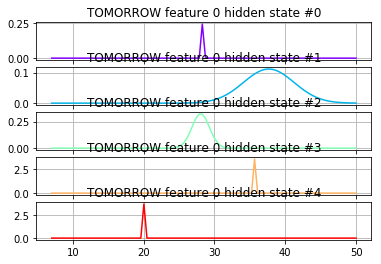

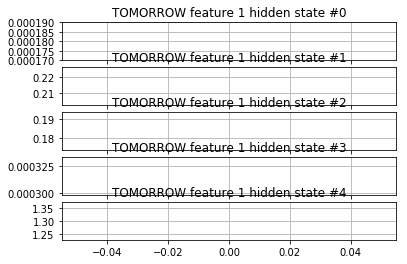

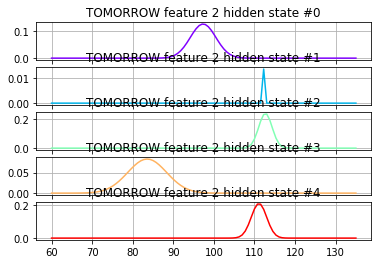

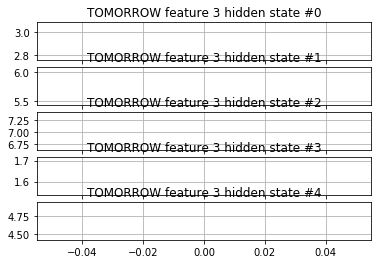

In [22]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [23]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [24]:
from sklearn.model_selection import KFold

training = asl.build_training(features_polar_norm) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [25]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [26]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

#### Cross-Validation Selector (SelectorCV)

In [27]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV
# import json

all_features = {
                    'features_ground': features_ground, 
                    'features_polar': features_polar, 
                    'features_delta': features_delta, 
                    'features_norm': features_norm, 
                    'features_custom': features_custom
                }
result = {} # the result object to be plotted

# Initialize the result data structure
for word in words_to_train:
    result[word] = {}
    result[word]['duration'] = []
    result[word]['num_states'] = []
    
for features_name, features in all_features.items():
    print("\n\nFor {}: {}".format(features_name, ', '.join(features)))
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()

    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            (result[word]['duration']).append(end)
            (result[word]['num_states']).append(model.n_components)
            print("\tTraining complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("\tTraining failed for {}".format(word))

# To inspect the result object (debug)
# print(json.dumps(result, indent=1))



For features_custom: grnd-rx-norm, grnd-ry-norm, grnd-lx-norm, grnd-ly-norm, polar-rr-norm, polar-rtheta-norm, polar-lr-norm, polar-ltheta-norm, delta-polar-rr-norm, delta-polar-rtheta-norm, delta-polar-lr-norm, delta-polar-ltheta-norm
	Training complete for FISH with 11 states with time 0.5999764330044854 seconds
	Training complete for BOOK with 2 states with time 5.637818816001527 seconds
	Training complete for VEGETABLE with 15 states with time 2.451754264999181 seconds
	Training complete for FUTURE with 2 states with time 4.655093040011707 seconds
	Training complete for JOHN with 7 states with time 68.9844633499888 seconds


For features_norm: norm-rx, norm-ry, norm-lx, norm-ly
	Training complete for FISH with 8 states with time 0.9482269879954401 seconds
	Training complete for BOOK with 2 states with time 7.509897578012897 seconds
	Training complete for VEGETABLE with 2 states with time 2.9989832669962198 seconds
	Training complete for FUTURE with 3 states with time 6.2565329080

#### Comparison of the plots of the duration of different features using Cross-Validation (SelectorCV)

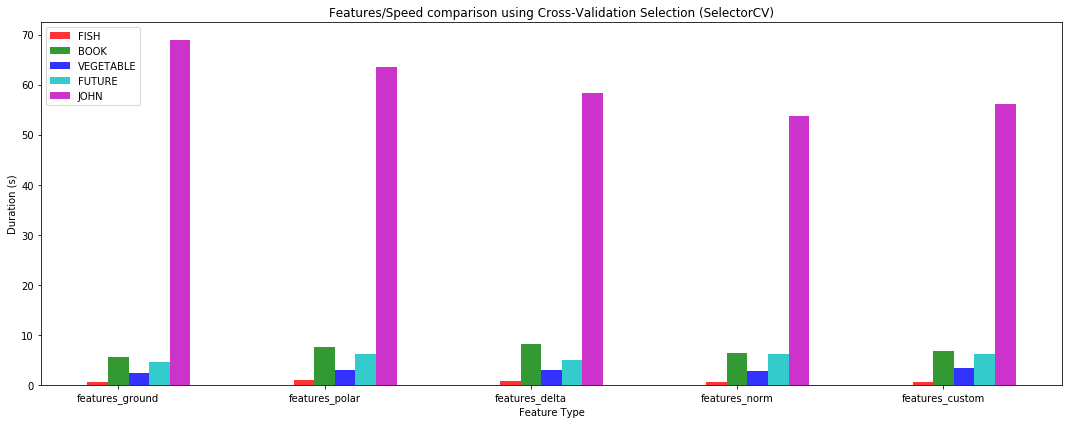

In [28]:
import numpy  as  np
import matplotlib.pyplot as plt
 
features_listing = ('features_ground', 'features_polar', 'features_delta', 'features_norm', 'features_custom')
# features_listing = ('ground', 'polar', 'delta', 'norm', 'custom')
spacing = len(features_listing)

# Create the plot
fig, ax = plt.subplots()
index = np.arange(len(features_listing))
bar_width = 0.10
opacity = 0.80

fig.set_figheight(6)
fig.set_figwidth(15)
 
plt.bar(index, tuple(result['FISH']['duration']), bar_width, alpha=opacity, color='r', label='FISH')
plt.bar(index + bar_width, tuple(result['BOOK']['duration']), bar_width, alpha=opacity, color='g', label='BOOK')
plt.bar(index + (2 * bar_width), tuple(result['VEGETABLE']['duration']), bar_width, alpha=opacity, color='b', label='VEGETABLE')
plt.bar(index + (3 * bar_width), tuple(result['FUTURE']['duration']), bar_width, alpha=opacity, color='c', label='FUTURE')
plt.bar(index + (4 * bar_width), tuple(result['JOHN']['duration']), bar_width, alpha=opacity, color='m', label='JOHN')

plt.xlabel('Feature Type')
plt.ylabel('Duration (s)')
plt.title('Features/Speed comparison using Cross-Validation Selection (SelectorCV)')
plt.xticks(index + bar_width, features_listing)
plt.legend()
plt.tight_layout()
fig.savefig('charts/cv-speed.png') # save to file
plt.show()
plt.close()

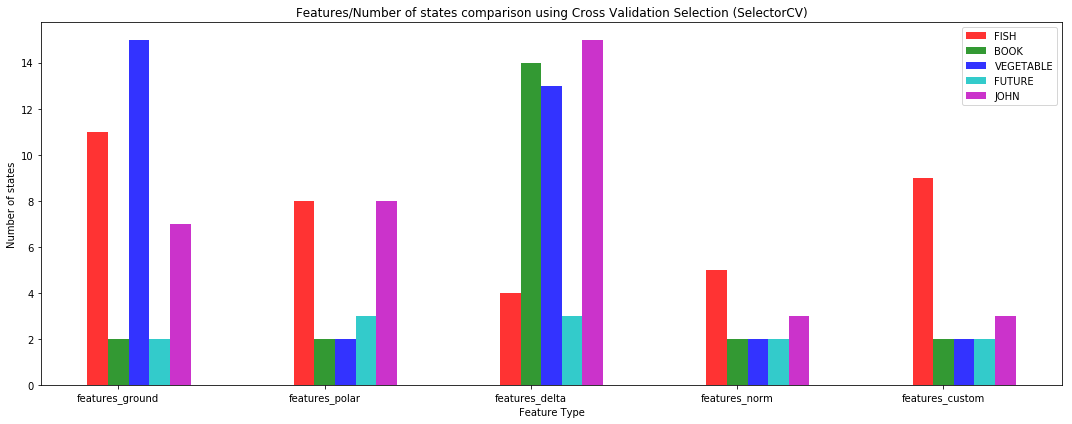

In [29]:
import numpy  as  np
import matplotlib.pyplot as plt
 
features_listing = ('features_ground', 'features_polar', 'features_delta', 'features_norm', 'features_custom')
# features_listing = ('ground', 'polar', 'delta', 'norm', 'custom')
spacing = len(features_listing)

# Create the plot
fig, ax = plt.subplots()
index = np.arange(len(features_listing))
bar_width = 0.10
opacity = 0.80

fig.set_figheight(6)
fig.set_figwidth(15)
 
plt.bar(index, tuple(result['FISH']['num_states']), bar_width, alpha=opacity, color='r', label='FISH')
plt.bar(index + bar_width, tuple(result['BOOK']['num_states']), bar_width, alpha=opacity, color='g', label='BOOK')
plt.bar(index + (2 * bar_width), tuple(result['VEGETABLE']['num_states']), bar_width, alpha=opacity, color='b', label='VEGETABLE')
plt.bar(index + (3 * bar_width), tuple(result['FUTURE']['num_states']), bar_width, alpha=opacity, color='c', label='FUTURE')
plt.bar(index + (4 * bar_width), tuple(result['JOHN']['num_states']), bar_width, alpha=opacity, color='m', label='JOHN')

plt.xlabel('Feature Type')
plt.ylabel('Number of states')
plt.title('Features/Number of states comparison using Cross Validation Selection (SelectorCV)')
plt.xticks(index + bar_width, features_listing)
plt.legend()
plt.tight_layout()
fig.savefig('charts/cv-states.png') # save to file
plt.show()
plt.close()

#### BIC Selector (SelectorBIC)

In [30]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

all_features = {
                    'features_ground': features_ground, 
                    'features_polar': features_polar, 
                    'features_delta': features_delta, 
                    'features_norm': features_norm, 
                    'features_custom': features_custom
                }
bic_result = {} # the result object to be plotted

# Initialize the result data structure
for word in words_to_train:
    bic_result[word] = {}
    bic_result[word]['duration'] = []
    bic_result[word]['num_states'] = []

for features_name, features in all_features.items():
    print("\n\nFor {}: {}".format(features_name, ', '.join(features)))
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorBIC(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        
        if model is not None:
            (bic_result[word]['duration']).append(end)
            (bic_result[word]['num_states']).append(model.n_components)
            print("\tTraining complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("\tTraining failed for {}".format(word))



For features_custom: grnd-rx-norm, grnd-ry-norm, grnd-lx-norm, grnd-ly-norm, polar-rr-norm, polar-rtheta-norm, polar-lr-norm, polar-ltheta-norm, delta-polar-rr-norm, delta-polar-rtheta-norm, delta-polar-lr-norm, delta-polar-ltheta-norm
	Training complete for FISH with 3 states with time 0.7352593599935062 seconds
	Training complete for BOOK with 2 states with time 3.251311545012868 seconds
	Training complete for VEGETABLE with 2 states with time 1.0857363209943287 seconds
	Training complete for FUTURE with 2 states with time 2.37277216099028 seconds
	Training complete for JOHN with 2 states with time 43.73058796999976 seconds


For features_norm: norm-rx, norm-ry, norm-lx, norm-ly
	Training complete for FISH with 2 states with time 0.6806379699992249 seconds
	Training complete for BOOK with 2 states with time 3.0199616119934944 seconds
	Training complete for VEGETABLE with 2 states with time 1.22180112299975 seconds
	Training complete for FUTURE with 2 states with time 3.446259912991

#### Comparison of the plots of the duration of different features using BIC Selection (SelectorBIC)

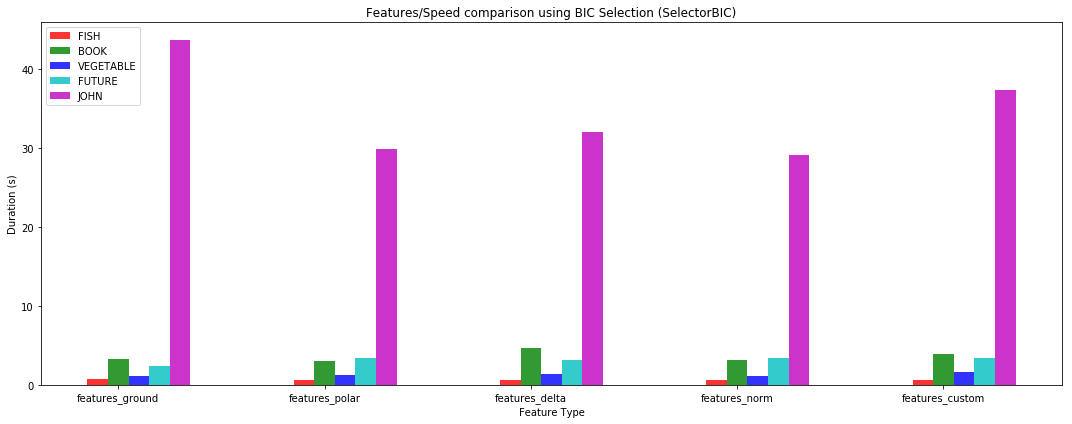

In [31]:
import numpy  as  np
import matplotlib.pyplot as plt
 
features_listing = ('features_ground', 'features_polar', 'features_delta', 'features_norm', 'features_custom')
# features_listing = ('ground', 'polar', 'delta', 'norm', 'custom')
spacing = len(features_listing)

# Create the plot
fig, ax = plt.subplots()
index = np.arange(len(features_listing))
bar_width = 0.10
opacity = 0.80

fig.set_figheight(6)
fig.set_figwidth(15)
 
plt.bar(index, tuple(bic_result['FISH']['duration']), bar_width, alpha=opacity, color='r', label='FISH')
plt.bar(index + bar_width, tuple(bic_result['BOOK']['duration']), bar_width, alpha=opacity, color='g', label='BOOK')
plt.bar(index + (2 * bar_width), tuple(bic_result['VEGETABLE']['duration']), bar_width, alpha=opacity, color='b', label='VEGETABLE')
plt.bar(index + (3 * bar_width), tuple(bic_result['FUTURE']['duration']), bar_width, alpha=opacity, color='c', label='FUTURE')
plt.bar(index + (4 * bar_width), tuple(bic_result['JOHN']['duration']), bar_width, alpha=opacity, color='m', label='JOHN')

plt.xlabel('Feature Type')
plt.ylabel('Duration (s)')
plt.title('Features/Speed comparison using BIC Selection (SelectorBIC)')
plt.xticks(index + bar_width, features_listing)
plt.legend()
plt.tight_layout()
fig.savefig('charts/bic-speed.png') # save to file
plt.show()
plt.close()

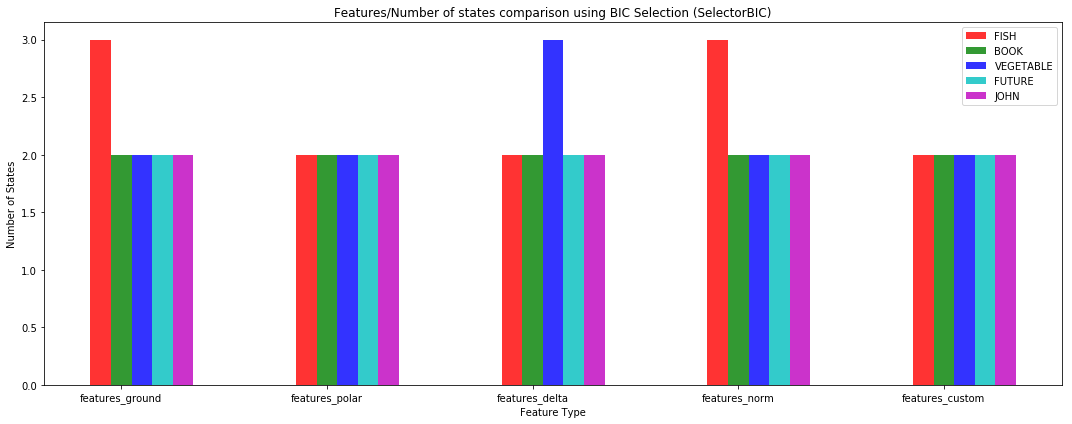

In [32]:
import numpy  as  np
import matplotlib.pyplot as plt
 
features_listing = ('features_ground', 'features_polar', 'features_delta', 'features_norm', 'features_custom')
# features_listing = ('ground', 'polar', 'delta', 'norm', 'custom')
spacing = len(features_listing)

# Create the plot
fig, ax = plt.subplots()
index = np.arange(len(features_listing))
bar_width = 0.10
opacity = 0.80

fig.set_figheight(6)
fig.set_figwidth(15)
 
plt.bar(index, tuple(bic_result['FISH']['num_states']), bar_width, alpha=opacity, color='r', label='FISH')
plt.bar(index + bar_width, tuple(bic_result['BOOK']['num_states']), bar_width, alpha=opacity, color='g', label='BOOK')
plt.bar(index + (2 * bar_width), tuple(bic_result['VEGETABLE']['num_states']), bar_width, alpha=opacity, color='b', label='VEGETABLE')
plt.bar(index + (3 * bar_width), tuple(bic_result['FUTURE']['num_states']), bar_width, alpha=opacity, color='c', label='FUTURE')
plt.bar(index + (4 * bar_width), tuple(bic_result['JOHN']['num_states']), bar_width, alpha=opacity, color='m', label='JOHN')

plt.xlabel('Feature Type')
plt.ylabel('Number of States')
plt.title('Features/Number of states comparison using BIC Selection (SelectorBIC)')
plt.xticks(index + bar_width, features_listing)
plt.legend()
plt.tight_layout()
fig.savefig('charts/bic-states.png') # save to file
plt.show()
plt.close()

#### DIC Selector (SelectorDIC)

In [33]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

all_features = {
                    'features_ground': features_ground, 
                    'features_polar': features_polar, 
                    'features_delta': features_delta, 
                    'features_norm': features_norm, 
                    'features_custom': features_custom
                }
dic_result = {} # the result object to be plotted

# Initialize the result data structure
for word in words_to_train:
    dic_result[word] = {}
    dic_result[word]['duration'] = []
    dic_result[word]['num_states'] = []

for features_name, features in all_features.items():
    print("\n\nFor {}: {}".format(features_name, ', '.join(features)))
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorDIC(sequences, Xlengths, word, 
                        min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            (dic_result[word]['duration']).append(end)
            (dic_result[word]['num_states']).append(model.n_components)
            print("\tTraining complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("\tTraining failed for {}".format(word))



For features_custom: grnd-rx-norm, grnd-ry-norm, grnd-lx-norm, grnd-ly-norm, polar-rr-norm, polar-rtheta-norm, polar-lr-norm, polar-ltheta-norm, delta-polar-rr-norm, delta-polar-rtheta-norm, delta-polar-lr-norm, delta-polar-ltheta-norm
	Training complete for FISH with 2 states with time 3.7582637509913184 seconds
	Training complete for BOOK with 15 states with time 6.183272914990084 seconds
	Training complete for VEGETABLE with 9 states with time 4.044274945001234 seconds
	Training complete for FUTURE with 14 states with time 5.346229518996552 seconds
	Training complete for JOHN with 15 states with time 47.43231012200704 seconds


For features_norm: norm-rx, norm-ry, norm-lx, norm-ly
	Training complete for FISH with 2 states with time 3.7266674990096362 seconds
	Training complete for BOOK with 15 states with time 6.048264103999827 seconds
	Training complete for VEGETABLE with 5 states with time 4.516092256002594 seconds
	Training complete for FUTURE with 15 states with time 6.5545408

#### Comparison of the plots of the duration of different features using DIC Selection (SelectorDIC)

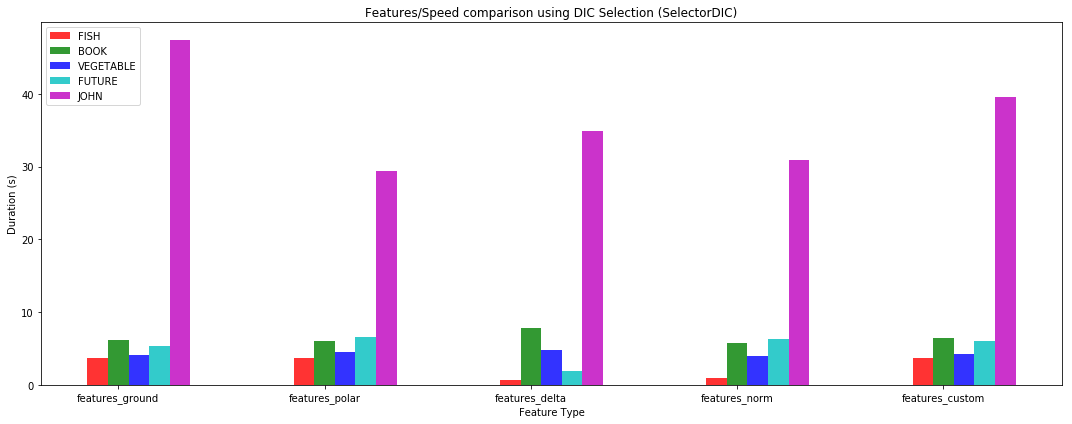

In [34]:
import numpy  as  np
import matplotlib.pyplot as plt
 
features_listing = ('features_ground', 'features_polar', 'features_delta', 'features_norm', 'features_custom')
# features_listing = ('ground', 'polar', 'delta', 'norm', 'custom')
spacing = len(features_listing)

# Create the plot
fig, ax = plt.subplots()
index = np.arange(len(features_listing))
bar_width = 0.10
opacity = 0.80

fig.set_figheight(6)
fig.set_figwidth(15)
 
plt.bar(index, tuple(dic_result['FISH']['duration']), bar_width, alpha=opacity, color='r', label='FISH')
plt.bar(index + bar_width, tuple(dic_result['BOOK']['duration']), bar_width, alpha=opacity, color='g', label='BOOK')
plt.bar(index + (2 * bar_width), tuple(dic_result['VEGETABLE']['duration']), bar_width, alpha=opacity, color='b', label='VEGETABLE')
plt.bar(index + (3 * bar_width), tuple(dic_result['FUTURE']['duration']), bar_width, alpha=opacity, color='c', label='FUTURE')
plt.bar(index + (4 * bar_width), tuple(dic_result['JOHN']['duration']), bar_width, alpha=opacity, color='m', label='JOHN')

plt.xlabel('Feature Type')
plt.ylabel('Duration (s)')
plt.title('Features/Speed comparison using DIC Selection (SelectorDIC)')
plt.xticks(index + bar_width, features_listing)
plt.legend()
plt.tight_layout()
fig.savefig('charts/dic-speed.png') # save to file
plt.show()
plt.close()

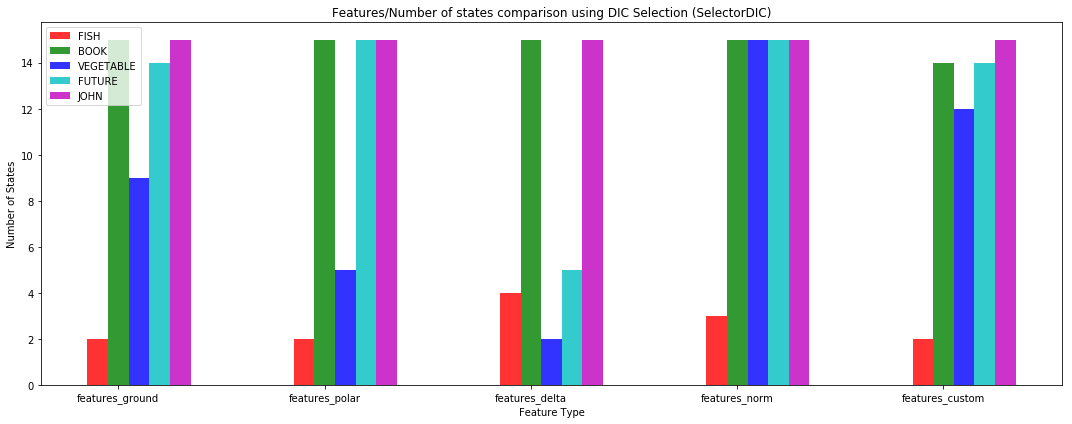

In [35]:
import numpy  as  np
import matplotlib.pyplot as plt
 
features_listing = ('features_ground', 'features_polar', 'features_delta', 'features_norm', 'features_custom')
# features_listing = ('ground', 'polar', 'delta', 'norm', 'custom')
spacing = len(features_listing)

# Create the plot
fig, ax = plt.subplots()
index = np.arange(len(features_listing))
bar_width = 0.10
opacity = 0.80

fig.set_figheight(6)
fig.set_figwidth(15)
 
plt.bar(index, tuple(dic_result['FISH']['num_states']), bar_width, alpha=opacity, color='r', label='FISH')
plt.bar(index + bar_width, tuple(dic_result['BOOK']['num_states']), bar_width, alpha=opacity, color='g', label='BOOK')
plt.bar(index + (2 * bar_width), tuple(dic_result['VEGETABLE']['num_states']), bar_width, alpha=opacity, color='b', label='VEGETABLE')
plt.bar(index + (3 * bar_width), tuple(dic_result['FUTURE']['num_states']), bar_width, alpha=opacity, color='c', label='FUTURE')
plt.bar(index + (4 * bar_width), tuple(dic_result['JOHN']['num_states']), bar_width, alpha=opacity, color='m', label='JOHN')

plt.xlabel('Feature Type')
plt.ylabel('Number of States')
plt.title('Features/Number of states comparison using DIC Selection (SelectorDIC)')
plt.xticks(index + bar_width, features_listing)
plt.legend()
plt.tight_layout()
fig.savefig('charts/dic-states.png') # save to file
plt.show()
plt.close()

#### Miniaturized Model Selector Speed comparison

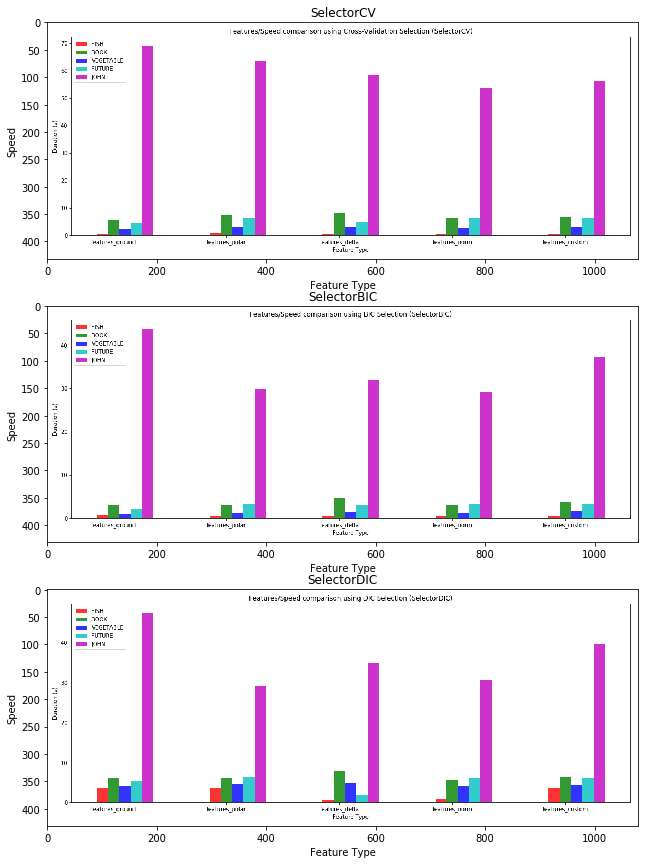

In [36]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
labels = ['SelectorCV', 'SelectorBIC', 'SelectorDIC']
for img_path in ['charts/cv-speed.png', 'charts/bic-speed.png', 'charts/dic-speed.png']:
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(70,20))
columns = 1
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(labels[i])
    plt.xlabel('Feature Type')
    plt.ylabel('Speed')
    plt.imshow(image)

#### Miniaturized Model Selector Number of States comparison

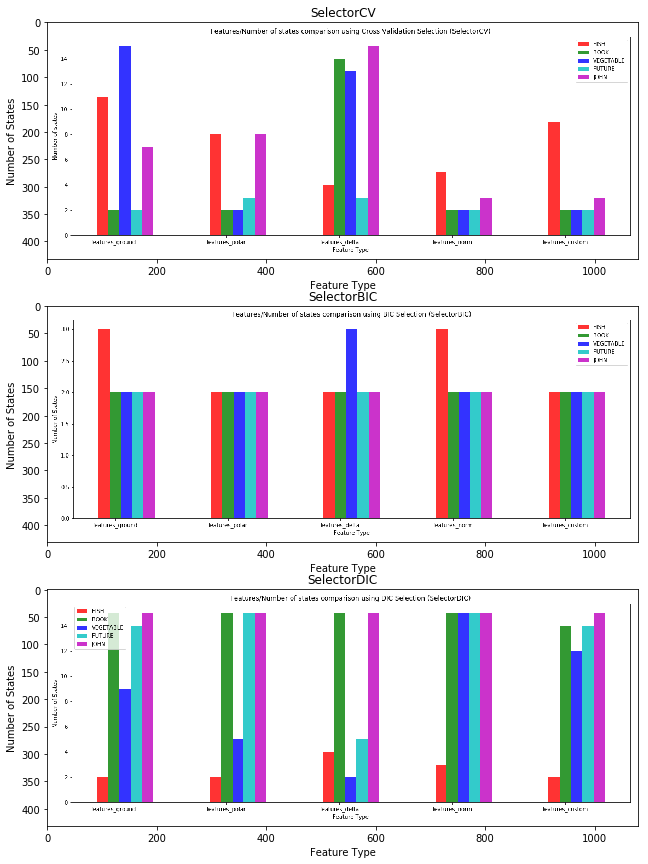

In [37]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
labels = ['SelectorCV', 'SelectorBIC', 'SelectorDIC']
for img_path in ['charts/cv-states.png', 'charts/bic-states.png', 'charts/dic-states.png']:
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(70,20))
columns = 1
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(labels[i])
    plt.xlabel('Feature Type')
    plt.ylabel('Number of States')
    plt.imshow(image)

**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:** 
The charts above shows the comparison of different feature selections according to their speed of execution and the number of states required to complete the training. It can be observed that behavior of each feature selection is similar for the 3 models selections under consideration. i.e. *features_ground*, *features_polar*, *features_delta*, *features_norm* and *features_custom* result in similar outcomes according to the results obtained above.

Looking at the minituarized charts above, we can closely compare the 3 model selections, namely __SelectorCV__, __SelectorBIC__ and __SelectorDIC__. From the chart, we can deduce that *SelectorBIC* performs the fastest, followed by *SelectorCV*. Regarding the number of states required to complete a training, *SelectorCV* requires the least number of states overall. 

The DIC selector is significantly more complex than the other two selectors, requiring a higher number of states to complete a training, as can be deduced from the charts above. Like the BIC selector, it uses all the data in the training set to build its model. Its main advantage seems to be that it improves "data separation" by choosing the model that yields the largest difference in log likelihood for a word compared to the average log likelihood of the rest of the words in the training data. __SelectorDIC__ when compared to the other selectors has the highest amount of overfitting, whereas __SelectorCV__ generalizes best and shows the least amount of overfitting, while being quite fast at the same time.


<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [38]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 82.475s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [39]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [40]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [41]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [42]:
# TODO Choose a feature set and model selector
# features = features_polar # change as needed
model_selector = SelectorCV # change as needed
all_features = {
                    'features_ground': features_ground, 
                    'features_polar': features_polar, 
                    'features_delta': features_delta, 
                    'features_norm': features_norm, 
                    'features_custom': features_custom
                }

# TODO Recognize the test set and display the result with the show_errors method
# models = train_all_words(features, model_selector)
# test_set = asl.build_test(features)
# probabilities, guesses = recognize(models, test_set)
# show_errors(guesses, test_set)

# All Features test using CV
print("\n***************************        SelectorCV model      **************************")

# TODO Recognize the test set and display the result with the show_errors method
for features_name, features in all_features.items():
    models = train_all_words(features, model_selector)
    test_set = asl.build_test(features)
    probabilities, guesses = recognize(models, test_set)
    print("\nWER results for Feature Set: %r" % features_name)
    show_errors(guesses, test_set)


***************************        SelectorCV model      **************************

WER results for Feature Set: 'features_custom'

**** WER = 0.550561797752809
Total correct: 80 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN *NEW *ARRIVE                                             JOHN WRITE HOMEWORK
   67: JOHN *GIVE1 *VISIT BUY HOUSE                                  JOHN FUTURE NOT BUY HOUSE
    7: JOHN *NEW GO CAN                                              JOHN CAN GO CAN
  201: JOHN TELL *LOVE *WOMAN BUY HOUSE                              JOHN TELL MARY IX-1P BUY HOUSE
   74: JOHN *WHO VISIT *LOVE                                         JOHN NOT VISIT MARY
  119: *PREFER *BUY1 *WOMAN *BLAME *VISIT                            SUE BUY IX CAR BLUE
   12: JOHN *CAR *CAR *HOUSE                                         JOHN CAN GO CAN
   77:


WER results for Feature Set: 'features_ground'

**** WER = 0.651685393258427
Total correct: 62 out of 178
Video  Recognized                                                    Correct
  100: *SOMETHING-ONE NEW CAR *BOOK                                  POSS NEW CAR BREAK-DOWN
    2: *WHO *BOOK *NEW                                               JOHN WRITE HOMEWORK
   67: *IX *POSS NOT *ARRIVE HOUSE                                   JOHN FUTURE NOT BUY HOUSE
    7: JOHN *WHAT GO *HAVE                                           JOHN CAN GO CAN
  201: JOHN *MARY *WOMAN *LIKE *BOOK HOUSE                           JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *IX *GO *LOVE                                             JOHN NOT VISIT MARY
  119: *VEGETABLE *BUY1 *HAVE *WHAT *SUE                             SUE BUY IX CAR BLUE
   12: JOHN *TEACHER *WHAT CAN                                       JOHN CAN GO CAN
   77: *IX *GIVE1 *LOVE                                              ANN BLAME MARY
  142: 

In [43]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method
model_selector = SelectorBIC # change as needed
all_features = {
                    'features_ground': features_ground, 
                    'features_polar': features_polar, 
                    'features_delta': features_delta, 
                    'features_norm': features_norm, 
                    'features_custom': features_custom
                }

# All Features test using BIC
print("\n***************************        SelectorBIC model      **************************")

# TODO Recognize the test set and display the result with the show_errors method
for features_name, features in all_features.items():
    models = train_all_words(features, model_selector)
    test_set = asl.build_test(features)
    probabilities, guesses = recognize(models, test_set)
    print("\nWER results for Feature Set: %r" % features_name)
    show_errors(guesses, test_set)


***************************        SelectorBIC model      **************************

WER results for Feature Set: 'features_custom'

**** WER = 0.550561797752809
Total correct: 80 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: *FUTURE WRITE HOMEWORK                                        JOHN WRITE HOMEWORK
   67: JOHN FUTURE *WHO BUY HOUSE                                    JOHN FUTURE NOT BUY HOUSE
    7: JOHN *NEW GO CAN                                              JOHN CAN GO CAN
  201: JOHN *MAN *IX *WOMAN *STUDENT HOUSE                           JOHN TELL MARY IX-1P BUY HOUSE
   74: JOHN NOT *GIVE *LOVE                                          JOHN NOT VISIT MARY
  119: *PREFER *BUY1 *SOMETHING-ONE CAR *VISIT                       SUE BUY IX CAR BLUE
   12: JOHN CAN *CAR CAN                                             JOHN CAN GO CAN
   77


WER results for Feature Set: 'features_ground'

**** WER = 0.6348314606741573
Total correct: 65 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: *WHO WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
   67: *LIKE *MOTHER NOT *ARRIVE HOUSE                               JOHN FUTURE NOT BUY HOUSE
    7: JOHN *GO1 *HAVE *WHAT                                         JOHN CAN GO CAN
  201: JOHN *MAN *GIVE *JOHN BUY HOUSE                               JOHN TELL MARY IX-1P BUY HOUSE
   74: *MARY *BILL *MARY MARY                                        JOHN NOT VISIT MARY
  119: *PREFER *BUY1 *HAVE CAR *SUE                                  SUE BUY IX CAR BLUE
   12: JOHN CAN *CAN CAN                                             JOHN CAN GO CAN
   77: *LOVE BLAME *LOVE                                             ANN BLAME MARY
  142:

In [44]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method
model_selector = SelectorDIC # change as needed
all_features = {
                    'features_ground': features_ground, 
                    'features_polar': features_polar, 
                    'features_delta': features_delta, 
                    'features_norm': features_norm, 
                    'features_custom': features_custom
                }

# All Features test using BIC
print("\n***************************        SelectorDIC model      **************************")

# TODO Recognize the test set and display the result with the show_errors method
for features_name, features in all_features.items():
    models = train_all_words(features, model_selector)
    test_set = asl.build_test(features)
    probabilities, guesses = recognize(models, test_set)
    print("\nWER results for Feature Set: %r" % features_name)
    show_errors(guesses, test_set)


***************************        SelectorDIC model      **************************

WER results for Feature Set: 'features_custom'

**** WER = 0.4887640449438202
Total correct: 91 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN *HOUSE *ARRIVE                                           JOHN WRITE HOMEWORK
   67: JOHN FUTURE *JOHN BUY HOUSE                                   JOHN FUTURE NOT BUY HOUSE
    7: JOHN *CAR GO CAN                                              JOHN CAN GO CAN
  201: *SOMETHING-ONE *GIVE1 *WOMAN *WOMAN BUY HOUSE                 JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX NOT VISIT MARY                                            JOHN NOT VISIT MARY
  119: *MARY *BUY1 IX CAR *GO                                        SUE BUY IX CAR BLUE
   12: JOHN *HOUSE *ARRIVE *HOUSE                                    JOHN CAN GO CAN
   7


WER results for Feature Set: 'features_ground'

**** WER = 0.5786516853932584
Total correct: 75 out of 178
Video  Recognized                                                    Correct
  100: *IX NEW CAR BREAK-DOWN                                        POSS NEW CAR BREAK-DOWN
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
   67: JOHN FUTURE *MARY BUY HOUSE                                   JOHN FUTURE NOT BUY HOUSE
    7: *SOMETHING-ONE *CAR *ARRIVE *ARRIVE                           JOHN CAN GO CAN
  201: JOHN *MARY *LOVE *JOHN *GIVE1 HOUSE                           JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *GO *MARY MARY                                            JOHN NOT VISIT MARY
  119: *VISIT *BUY1 IX *BOX *IX                                      SUE BUY IX CAR BLUE
   12: *IX *WHAT *WHAT *HOUSE                                        JOHN CAN GO CAN
   77: *JOHN *GIVE1 *LOVE                                            ANN BLAME MARY
  142:

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**  
To ensure that a well-informed summary is obtained from the recognizer implementation, all the feature sets, namely, *Ground Features* (__features_ground__), *Polar Features* (__features_polar__), *Delta Features* (__features_delta__), *Normalized Features* (__features_norm__) and the *Custom Features* (__features_custom__) were evaluated for the 3 selection models: *Cross-Validation Selection* (__CV__), *Bayesian Information Criterion* (__BIC__) and *Discriminative Information Criterion* (__DIC__), and the results are provided above.

A detailed summary is provided below showing the Word Error Rate (WER) for each of the selections and the different feature sets implemented:

![Result Table](charts/recognizer-results.png "Result Table")

#### Best Feature Set Identification

The plot below shows that *Custom Features* (__features_custom__) performs best as it has the least Word Error Rate (WER). This is due to the fact that the feature set takes into cognizance different feature groups and thus benefits from the combination of the disparate sets.

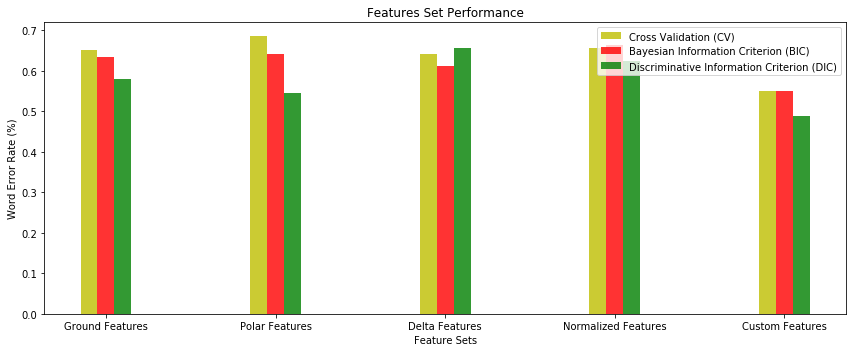

In [78]:
import numpy  as  np
import matplotlib.pyplot as plt
 
feature_sets = ('Ground Features', 'Polar Features', 'Delta Features', 'Normalized Features', 'Custom Features')
spacing = len(feature_sets)

# Create the plot
fig, ax = plt.subplots()
index = np.arange(len(feature_sets))
bar_width = 0.10
opacity = 0.80

fig.set_figheight(5)
fig.set_figwidth(12)

cv_result = [0.651685393258427, 0.6853932584269663, 0.6404494382022472, 0.6573033707865169, 0.550561797752809]
bic_result = [0.6348314606741573, 0.6404494382022472, 0.6123595505617978, 0.6629213483146067, 0.550561797752809]
dic_result = [0.5786516853932584, 0.5449438202247191, 0.6573033707865169, 0.6235955056179775, 0.4887640449438202]
 
plt.bar(index, cv_result, bar_width, alpha=opacity, color='y', label='Cross Validation (CV)')
plt.bar(index + bar_width, bic_result, bar_width, alpha=opacity, color='r', label='Bayesian Information Criterion (BIC)')
plt.bar(index + (2 * bar_width), dic_result, bar_width, alpha=opacity, color='g', label='Discriminative Information Criterion (DIC)')

plt.xlabel('Feature Sets')
plt.ylabel('Word Error Rate (%)')
plt.title('Features Set Performance')
plt.xticks(index + bar_width, feature_sets)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

#### Selection Criteria

The plot below shows that __Bayesian Information Criterion (BIC)__ and __Discriminative Information Criterion (DIC)__ performs much better than __Cross validation (CV)__ regarding model selection choice. 

The best performing combination is DIC using Custom Features set, which was able to predict __91__ out of __178 words__, resulting in the lowest Word Error Rate (WER) of __48.9%__. 

WER can be improved by utilizing neighbour distance information, as some word combinations are much more likely than others. For example, __"JOHN ARRIVE"__ is much more likely than __"MARY BOX"__, as illustrated in one of the results produced earlier. Neighboring information can easily be captured using *N-Gram Language Models*. Also, a better WER can probably be obtained by running the prediction multiple times and taking an average of the WER obtained.

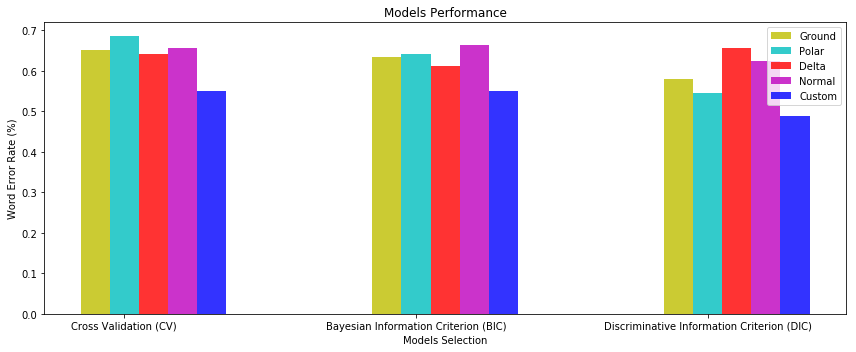

In [81]:
import numpy  as  np
import matplotlib.pyplot as plt
 
models_selection = ('Cross Validation (CV)', 'Bayesian Information Criterion (BIC)', 'Discriminative Information Criterion (DIC)')
spacing = len(models_selection)

# Create the plot
fig, ax = plt.subplots()
index = np.arange(len(models_selection))
bar_width = 0.10
opacity = 0.80

fig.set_figheight(5)
fig.set_figwidth(12)

ground_features_result = [0.651685393258427, 0.6348314606741573, 0.5786516853932584]
polar_features_result = [0.6853932584269663, 0.6404494382022472, 0.5449438202247191]
delta_features_result = [0.6404494382022472, 0.6123595505617978, 0.6573033707865169]
normalized_features_result = [0.6573033707865169, 0.6629213483146067, 0.6235955056179775]
custom_features_result = [0.550561797752809, 0.550561797752809, 0.4887640449438202]
 
plt.bar(index, ground_features_result, bar_width, alpha=opacity, color='y', label='Ground')
plt.bar(index + bar_width, polar_features_result, bar_width, alpha=opacity, color='c', label='Polar')
plt.bar(index + (2 * bar_width), delta_features_result, bar_width, alpha=opacity, color='r', label='Delta')
plt.bar(index + (3 * bar_width), normalized_features_result, bar_width, alpha=opacity, color='m', label='Normal')
plt.bar(index + (4 * bar_width), custom_features_result, bar_width, alpha=opacity, color='b', label='Custom')

plt.xlabel('Models Selection')
plt.ylabel('Word Error Rate (%)')
plt.title('Models Performance')
plt.xticks(index + bar_width, models_selection)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [45]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 57.153s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [46]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-2564.662695,-1.753202e+05,-3717.959230,-330.513568,-1917.200589,-382.325969,-2873.528478,-1041.209577,-4494.410087,-658.116291,...,-1868.385715,-210.031173,-2.825990e+05,-278.983071,-211.611880,-1266.658595,-681.591884,-754.633694,-3.448737e+05,-301.376322
1,-6791.690644,-1.628911e+06,-9809.478432,-118.958118,-20286.529893,-441.624171,-7970.543151,-113.149819,-4198.828746,-553.379536,...,-183.880329,-548.100050,-4.358747e+04,-341.874211,-111.098536,-4747.124223,-2127.407882,-1494.193684,-2.184680e+05,-596.329517
2,-9576.855303,-2.520507e+06,-16073.901762,-318.573229,-30774.600627,-914.958672,-11676.616479,-887.829275,-3877.682380,-1212.108472,...,-971.265547,-793.640362,-5.568856e+05,-760.664399,-483.978522,-7242.007128,-2088.568265,-1869.519352,-1.741097e+05,-1428.551017
3,-1061.709747,-2.940894e+06,-2555.973123,-279.642514,-592.956086,-255.377577,-567.224467,-1171.290246,-33897.899104,-711.342484,...,-5100.570599,-548.542614,-1.143249e+06,-742.223768,-565.158810,-11861.278942,-361.405907,-618.250716,-2.441728e+06,-521.070155
4,-1462.548501,-6.623752e+05,-3113.233070,-99.786725,-3344.153430,-57.323454,-638.972883,-164.498017,-846.567498,-49.611306,...,-956.054397,-64.713586,-6.011117e+05,-50.739092,-208.252232,-5502.558401,-458.991533,-812.568059,-3.652996e+05,-486.300055
